In [1]:
import torch
from diffusers import StableDiffusionPanoramaPipeline, DDIMScheduler
import matplotlib.pyplot as plt
import numpy as np

from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    DiffusionPipeline,
    DPMSolverMultistepScheduler,
    UNet2DConditionModel,
)

from PIL import Image

# Multi diffusion deep dive

/home/ubuntu/anaconda3/lib/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

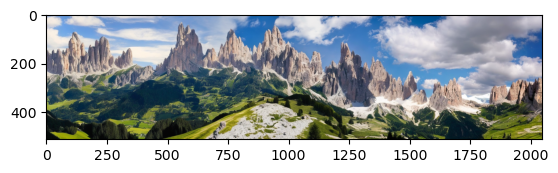

In [2]:
model_ckpt = "stabilityai/stable-diffusion-2-base"
scheduler = DDIMScheduler.from_pretrained(model_ckpt, subfolder="scheduler")
pipe = StableDiffusionPanoramaPipeline.from_pretrained(model_ckpt, scheduler=scheduler, torch_dtype=torch.float16)

pipe = pipe.to("cuda")

prompt = "a photo of the dolomites"
image = pipe(prompt).images[0]
plt.imshow(image)

# Section 1 Line by line reproducing mutlidiffusion

In [3]:
height = 512
width = 512
prompt = "a photo of the dolomites"
negative_prompt = "ugly"
num_inference_steps = 50
guidance_scale = 7.5
eta = 0.0
do_classifier_free_guidance = guidance_scale > 1.0
device = pipe._execution_device
batch_size = 1
num_images_per_prompt = 1
torch.manual_seed(32)

**Step 1 Prepare timesteps**

In [4]:
from Kai_util import _encode_prompt

model_ckpt ="stabilityai/stable-diffusion-2"
scheduler = DDIMScheduler.from_pretrained(model_ckpt, subfolder="scheduler")
# pipeline = DiffusionPipeline.from_pretrained(
#     model_ckpt,
#     torch_dtype=torch.float16,
#     safety_checker=None,
#     revision=False,
# )

In [5]:
# Encode input prompt
with torch.no_grad():
    prompt_embeds = pipe._encode_prompt(
        prompt,
        device = device,
        num_images_per_prompt = 1,
        do_classifier_free_guidance = do_classifier_free_guidance,
        negative_prompt = negative_prompt,)
    print(prompt_embeds.shape)

torch.Size([2, 77, 1024])


**Step 2 Prepare timesteps**

In [6]:
pipe.scheduler.set_timesteps(num_inference_steps, device=device)
timesteps = pipe.scheduler.timesteps
print(timesteps)

tensor([981, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761, 741, 721,
        701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501, 481, 461, 441,
        421, 401, 381, 361, 341, 321, 301, 281, 261, 241, 221, 201, 181, 161,
        141, 121, 101,  81,  61,  41,  21,   1], device='cuda:0')


**Step 3 Prepare latent variables**

latent是None，所以初始化是random noise

也可以初始化成其他想要的latents

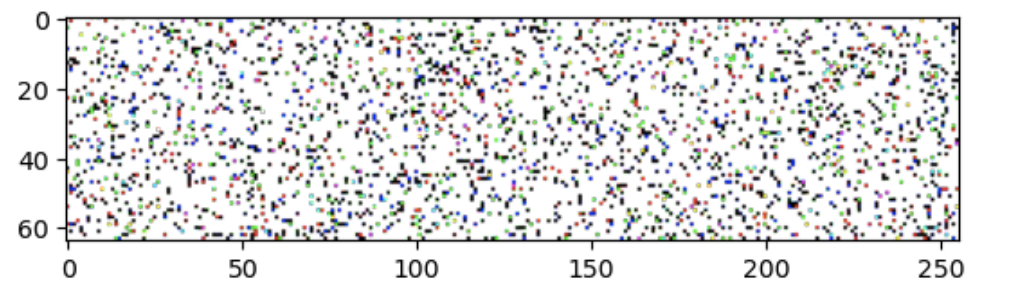

4
torch.Size([1, 4, 64, 64])


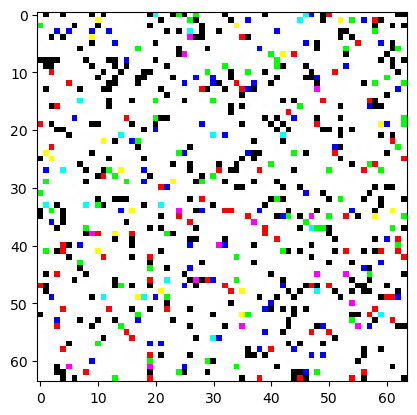

In [7]:
with torch.no_grad():
    num_channels_latents = pipe.unet.in_channels
    print(num_channels_latents)
    latents = pipe.prepare_latents(
        batch_size * num_images_per_prompt,
        num_channels_latents,
        height,
        width,
        torch.float16,
        device,
        generator = None,
        latents = None,
    )
plt.imshow(latents[0].permute(1,2,0).cpu().detach().numpy().astype(np.uint8))
print(latents.shape)

In [8]:
img = Image.fromarray(latents[0].permute(1,2,0).cpu().detach().numpy().astype(np.uint8))
img.save("noise.png")

**Step 4 Define panorama grid and initialize views for synthesis**

views 包含了多个小图中每一块noisy image的横纵坐标,  h_start, h_end, w_start, w_end
从一张图出发，横向移动8格，纵向移动8格

In [9]:
views = pipe.get_views(height, width)
count = torch.zeros_like(latents)
value = torch.zeros_like(latents)

In [10]:
views # h_start, h_end, w_start, w_end

[(0, 64, 0, 64)]

**Step 5 Prepare extra step kwargs???**

In [11]:
extra_step_kwargs = pipe.prepare_extra_step_kwargs(generator = None, eta=eta)
print(extra_step_kwargs)

{'eta': 0.0, 'generator': None}


**Step 8 Denoising loop**

Each denoising step also includes refinement of the latents with respect to the views.

In [12]:
num_warmup_steps = len(timesteps) - num_inference_steps * pipe.scheduler.order

In [13]:
with torch.no_grad():
    for i, t in enumerate(timesteps):
        print(i,t)
        count.zero_()
        value.zero_()

        # generate views
        # Here, we iterate through different spatial crops of the latents and denoise them. These
        # denoised (latent) crops are then averaged to produce the final latent
        # for the current timestep via MultiDiffusion. Please see Sec. 4.1 in the
        # MultiDiffusion paper for more details: https://arxiv.org/abs/2302.08113
        for h_start, h_end, w_start, w_end in views:
            # get the latents corresponding to the current view coordinates
            latents_for_view = latents[:, :, h_start:h_end, w_start:w_end]

            # expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([latents_for_view] * 2) if do_classifier_free_guidance else latents
            latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            noise_pred = pipe.unet(
                latent_model_input,
                t,
                encoder_hidden_states=prompt_embeds,
                cross_attention_kwargs=None,
            ).sample

            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents_view_denoised = pipe.scheduler.step(
                noise_pred, t, latents_for_view, **extra_step_kwargs
            ).prev_sample
            value[:, :, h_start:h_end, w_start:w_end] += latents_view_denoised
            count[:, :, h_start:h_end, w_start:w_end] += 1

        # take the MultiDiffusion step. Eq. 5 in MultiDiffusion paper: https://arxiv.org/abs/2302.08113
        latents = torch.where(count > 0, value / count, value)

        # # call the callback, if provided
        # if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
        #     progress_bar.update()
        #     if callback is not None and i % callback_steps == 0:
        #         callback(i, t, latents)

0 tensor(981, device='cuda:0')
1 tensor(961, device='cuda:0')
2 tensor(941, device='cuda:0')
3 tensor(921, device='cuda:0')
4 tensor(901, device='cuda:0')
5 tensor(881, device='cuda:0')
6 tensor(861, device='cuda:0')
7 tensor(841, device='cuda:0')
8 tensor(821, device='cuda:0')
9 tensor(801, device='cuda:0')
10 tensor(781, device='cuda:0')
11 tensor(761, device='cuda:0')
12 tensor(741, device='cuda:0')
13 tensor(721, device='cuda:0')
14 tensor(701, device='cuda:0')
15 tensor(681, device='cuda:0')
16 tensor(661, device='cuda:0')
17 tensor(641, device='cuda:0')
18 tensor(621, device='cuda:0')
19 tensor(601, device='cuda:0')
20 tensor(581, device='cuda:0')
21 tensor(561, device='cuda:0')
22 tensor(541, device='cuda:0')
23 tensor(521, device='cuda:0')
24 tensor(501, device='cuda:0')
25 tensor(481, device='cuda:0')
26 tensor(461, device='cuda:0')
27 tensor(441, device='cuda:0')
28 tensor(421, device='cuda:0')
29 tensor(401, device='cuda:0')
30 tensor(381, device='cuda:0')
31 tensor(361, dev

In [14]:
latents_for_view.shape

torch.Size([1, 4, 64, 64])

In [15]:
latent_model_input.shape

torch.Size([2, 4, 64, 64])